# ETS, EMA, and ARIMA — Self‑Guided Notes (with Solved Exercises)

**Goal:** Learn and re‑learn time‑series essentials *without external context*:
- ETS (Error, Trend, Seasonality) **decomposition**
- SMA vs **EMA** (Exponential Moving Average) and `pandas.DataFrame.ewm`
- **ARIMA** (AR, I, MA), **stationarity**, **differencing**, **ADF test**

**Date:** 2025-09-22 (UTC)

### How to use this notebook
Each section follows: **What & Why → Steps → Worked Example(s) → Checks → Common Pitfalls**.  
All exercises are **solved**, so you can follow and replicate them later.
This notebook is **self‑contained** (it generates synthetic Airline data if no CSV is present).


---
## Requirements
- Python 3.x, `pandas`, `numpy`, `matplotlib`
- Optional: `statsmodels` (for ETS decomposition & ADF test)

> All plots use plain `matplotlib`.


## 0) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline  # Uncomment in classic Jupyter
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")
print("Ready. pandas:", pd.__version__)

Ready. pandas: 2.3.2


## 1) Data — Airline Passengers (load or generate)

**What & Why**  
We'll use the classic *Airline Passengers* monthly series (1949–1960). If the CSV isn't available,
we generate a realistic synthetic series with trend + yearly seasonality + noise.

**Expected structure**: one column of values, monthly `DatetimeIndex`.


In [2]:
from pathlib import Path

def load_airline_csv(possible_names=('AirlinePassengers.csv','airline_passengers.csv','Airline_Passengers.csv')):
    for name in possible_names:
        p = Path(name)
        if p.exists():
            df = pd.read_csv(p)
            # Flexible column handling
            date_col = None
            for c in df.columns:
                if str(c).lower().startswith('month') or str(c).lower().startswith('date'):
                    date_col = c; break
            value_col = None
            for c in df.columns:
                if c != date_col:
                    value_col = c; break
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
            df = df.dropna(subset=[date_col, value_col]).set_index(date_col).sort_index()
            df = df.rename(columns={value_col: 'Passengers'})
            # enforce monthly freq style index (not strictly required)
            return df[['Passengers']]
    return None

def make_synthetic_airline(start='1949-01-01', end='1960-12-01', seed=7):
    rng = np.random.default_rng(seed)
    idx = pd.date_range(start, end, freq='MS')  # Month Start
    n = len(idx)
    # Trend (slightly accelerating)
    t = np.arange(n)
    trend = 100 + 0.9*t + 0.004*(t**2)
    # Yearly seasonality (period=12)
    season = 15*np.sin(2*np.pi*t/12) + 8*np.cos(2*np.pi*t/12)
    noise = rng.normal(0, 6, size=n)
    y = trend + season + noise
    # Make it strictly positive and a bit "count-like"
    y = np.maximum(y, 1.0)
    df = pd.DataFrame({'Passengers': y}, index=idx)
    return df

airline = load_airline_csv()
if airline is None:
    print("CSV not found → using synthetic Airline series.")
    airline = make_synthetic_airline()

airline = airline.asfreq('MS')  # monthly start
airline = airline.dropna()
airline.head()

CSV not found → using synthetic Airline series.


,Passengers
1949-01-01,108.007381
1949-02-01,117.124676
1949-03-01,117.161554
1949-04-01,112.392449
1949-05-01,109.926356


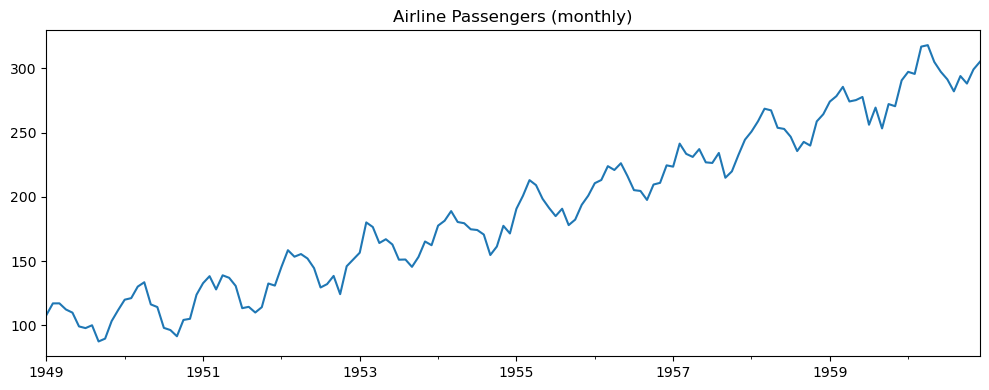

In [3]:
# Quick plot
plt.figure(figsize=(10,4))
airline['Passengers'].plot(title='Airline Passengers (monthly)')
plt.tight_layout()

**Checks**
- Index is monthly (`MS`), monotonic.
- Column name is `Passengers`.
- Values are positive (makes multiplicative decomposition meaningful).

**Common pitfalls**
- Not converting dates → string index behaves badly in time ops.
- Missing months → decomposition/ACF/PACF may complain.


## ✨ Concept: ETS
ETS stands for Error, Trend, and Seasonality.  
It helps you decompose a time series into its main components to better understand patterns.  
We'll use `statsmodels.tsa.seasonal_decompose` to visualize each component separately.

## ✨ Concept: EMA
EMA = Exponential Moving Average.  
It gives more weight to recent observations and reacts faster to changes than a simple moving average (SMA).

## ✨ Concept: ARIMA
ARIMA stands for AutoRegressive Integrated Moving Average.  
It is a powerful model for forecasting time series by combining:
- **AR (AutoRegressive):** relationship with past values  
- **I (Integrated):** differencing to remove trends  
- **MA (Moving Average):** modeling residual errors

### 🎯 Goal of ETS Decomposition
We decompose the time series into **Trend**, **Seasonality**, and **Residuals**.  
This helps us answer:
- Is there a clear upward or downward trend?
- Do we have repeating patterns (seasonality)?
- Are the residuals random (good sign) or still structured (bad model fit)?




## 2) ETS Decomposition (Error–Trend–Seasonality)

**What**  
ETS decomposition separates a series into **Trend**, **Seasonal**, and **Residual** components.

**Why**  
- See structure clearly (is there a trend? is seasonality stable?).
- Choose between **additive** vs **multiplicative** components.
  - *Additive*: `observed = trend + seasonal + residual` (roughly constant amplitude)
  - *Multiplicative*: `observed = trend × seasonal × residual` (amplitude grows with level)

**Steps**
1. Ensure a proper `DatetimeIndex` and regular frequency.
2. Optionally drop/forward‑fill missing values.
3. Call `statsmodels.tsa.seasonal.seasonal_decompose`.


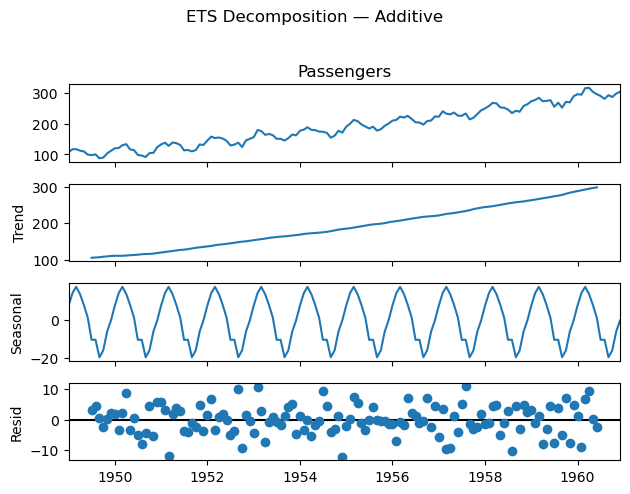

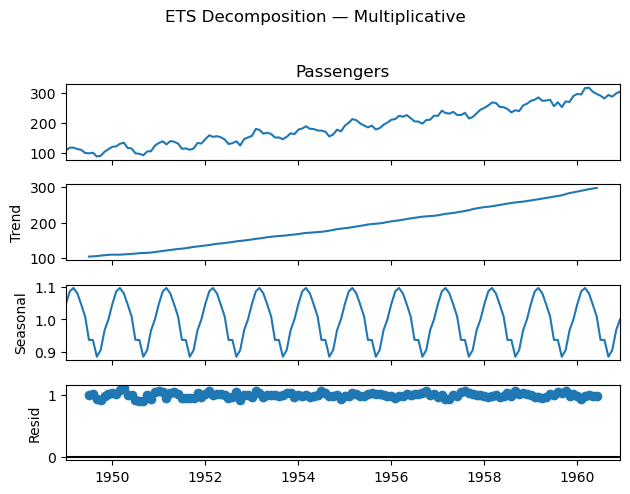

In [4]:
# Worked example: additive vs multiplicative
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    y = airline['Passengers']

    # Additive
    add_res = seasonal_decompose(y, model='additive', period=12)
    fig = add_res.plot()
    plt.suptitle('ETS Decomposition — Additive', y=1.02)
    plt.tight_layout()

    # Multiplicative
    mul_res = seasonal_decompose(y, model='multiplicative', period=12)
    fig = mul_res.plot()
    plt.suptitle('ETS Decomposition — Multiplicative', y=1.02)
    plt.tight_layout()

except Exception as e:
    print("Install statsmodels to run ETS decomposition. Error:", e)

**Interpretation tips**
- **Trend** sloping upward → long-run growth.
- **Seasonal** repeating pattern (e.g., summer peaks).
- **Residual** should look like unstructured noise (no pattern).

**Common pitfalls**
- Using multiplicative when the series has negatives or zeros.
- Missing/irregular frequencies → decomposition errors.


## 3) Moving Averages — SMA vs EMA

**What**
- **SMA (Simple Moving Average)**: mean over a rolling window (e.g., 6 or 12 months).
- **EMA (Exponential Moving Average)**: exponentially decaying weights favor **recent** values.

**Why**
- Smooth noise to reveal the level/trend.
- EMA reduces SMA lag and reacts faster to recent changes.

**Interpretation:**  
- SMA smooths the data but reacts slowly to sudden changes.  
- EMA responds faster and starts earlier (no NaN block at the beginning).  
- The smaller the `span` or `halflife`, the more responsive the EMA curve becomes.


### 3.1 SMA — quick review


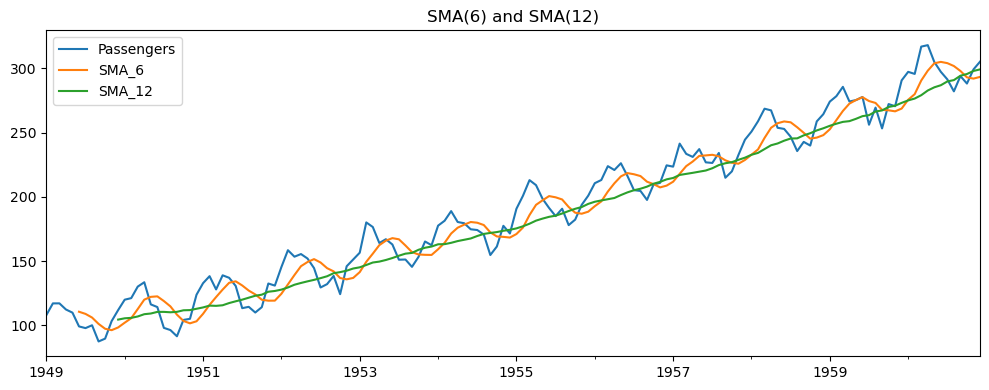

In [10]:
# Six- and twelve-month SMA on Passengers
df = airline.copy()
df['SMA_6']  = df['Passengers'].rolling(6).mean()
df['SMA_12'] = df['Passengers'].rolling(12).mean()

ax = df[['Passengers','SMA_6','SMA_12']].plot(figsize=(10,4), title='SMA(6) and SMA(12)')
plt.tight_layout()

**SMA Pitfalls**
- Short windows → noisy and still lagging.
- Never reaches local peaks/valleys (averaging effect).
- First `window-1` values are NaN (lag at start).

### 3.2 EMA — concept & parameters

**EMA recursion (adjust=False form)**  
Let \(\alpha \in (0,1] \).  
\[ \mathrm{EMA}_t = (1-\alpha)\,\mathrm{EMA}_{t-1} + \alpha\,x_t \]

**Weights decay** geometrically: recent points get more weight.

**Choosing \(\alpha\)** (pandas helpers):
- `span`  → \( \alpha = 2/(\text{span}+1) \)
- `com`   → \( \alpha = 1/(1+\text{com}) \)
- `halflife` → \( \alpha = 1 - e^{-\ln(2)/\text{halflife}} \)
- or pass `alpha` directly.

`adjust=True` (default) uses a normalized finite-sample formulation;  
`adjust=False` uses the recursive definition above.


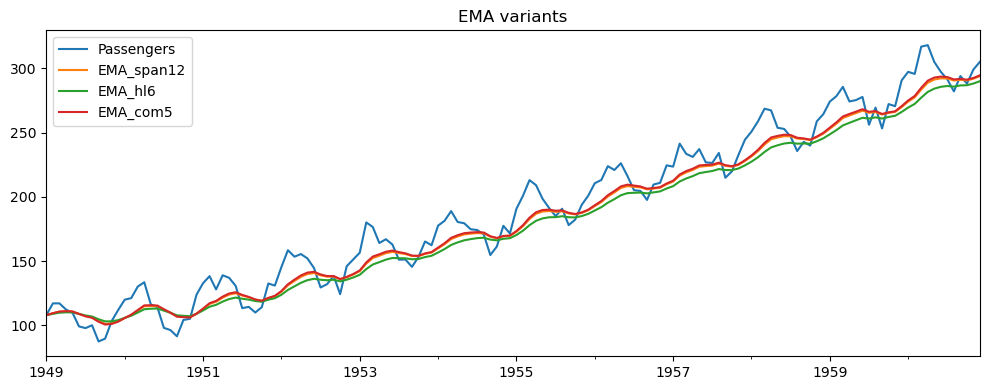

In [6]:
# EMA with different parameterizations
df = airline.copy()
df['EMA_span12'] = df['Passengers'].ewm(span=12, adjust=False).mean()
df['EMA_hl6']    = df['Passengers'].ewm(halflife=6, adjust=False).mean()
df['EMA_com5']   = df['Passengers'].ewm(com=5, adjust=False).mean()

ax = df[['Passengers','EMA_span12','EMA_hl6','EMA_com5']].plot(figsize=(10,4), title='EMA variants')
plt.tight_layout()

**Checks**
- EMA curves start earlier (no hard window NaN block) and track peaks better than SMA.
- Smaller `span` / `halflife` → more reactive (less smoothing).

**Common pitfalls**
- Using multiplicative models with zeros/negatives.
- Comparing EMAs with wildly different parameter scales.


## 4) Practical: Choose Additive vs Multiplicative (Solved)

**Task**  
Decide whether the Airline series is better modeled with *additive* or *multiplicative* ETS.

**Heuristic**  
If seasonal amplitude grows with the level → multiplicative. Otherwise → additive.


Additive seasonal amplitude: 36.912
Multiplicative seasonal amplitude (unitless, ~ratio): 0.211


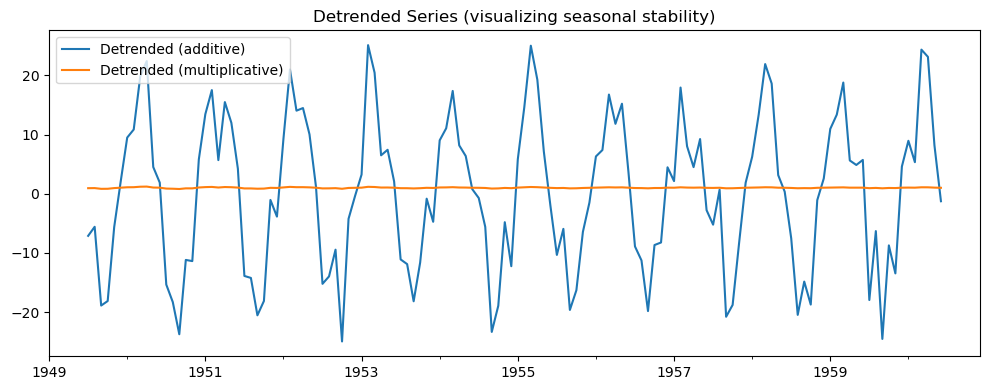

In [7]:
# Heuristic: compare seasonal ranges normalized by level
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    y = airline['Passengers']
    add = seasonal_decompose(y, model='additive', period=12)
    mul = seasonal_decompose(y, model='multiplicative', period=12)

    # Measure seasonal amplitude (peak-to-trough)
    add_seas_amp = (add.seasonal.max() - add.seasonal.min())
    mul_seas_amp = (mul.seasonal.max() - mul.seasonal.min())

    print(f"Additive seasonal amplitude: {add_seas_amp:,.3f}")
    print(f"Multiplicative seasonal amplitude (unitless, ~ratio): {mul_seas_amp:,.3f}")

    # Visual cue: overlay observed with detrended series
    y_det_add = y - add.trend
    y_det_mul = y / mul.trend
    plt.figure(figsize=(10,4))
    y_det_add.plot(label='Detrended (additive)')
    y_det_mul.plot(label='Detrended (multiplicative)')
    plt.title('Detrended Series (visualizing seasonal stability)')
    plt.legend(); plt.tight_layout()
except Exception as e:
    print("Install statsmodels to run this comparison. Error:", e)

**Conclusion (typical for Airline Passengers)**  
Seasonal swings tend to **grow** with the level → multiplicative is often more appropriate.
Your synthetic data may behave similarly depending on the generator.


## 5) ARIMA — Concepts (AR, I, MA) & Stationarity

**What**
- **AR** (AutoRegressive, p): regress on *past values*.
- **I** (Integrated, d): **differencing** to remove trend/seasonality → make series **stationary**.
- **MA** (Moving Average, q): regress on *past forecast errors* (residuals).

**Why stationarity?**
ARIMA assumes constant **mean** and **variance** over time.  
Non‑stationary series (trend, changing variance) violate this.

**Visual cues of non‑stationarity**
- Mean drifts upward/downward over time
- Variance changes over time
- Seasonal patterns present


### 5.1 Differencing

**First difference (remove trend):**  
\[ y'_t = y_t - y_{t-1} \]

**Seasonal difference (period s, e.g., 12 months):**  
\[ y''_t = y_t - y_{t-s} \]

You can combine: first difference **and** seasonal difference.  
Each differencing step loses rows at the start.


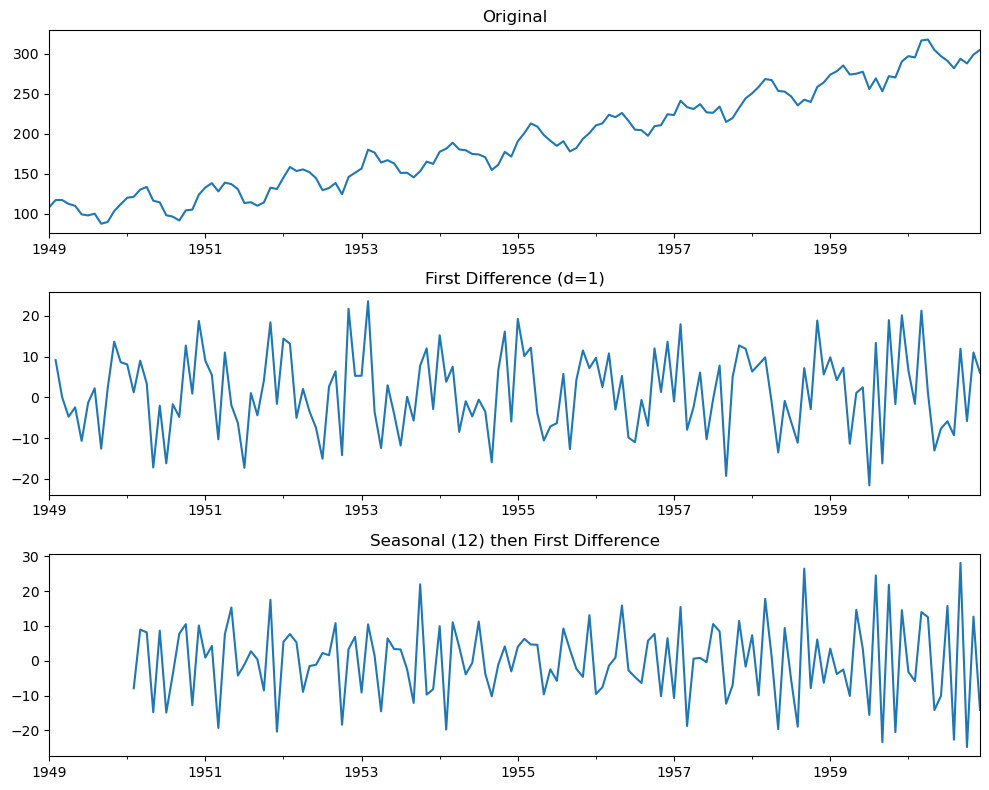

In [8]:
y = airline['Passengers']

# First difference
diff1 = y.diff(1)

# Seasonal difference (12)
diff12 = y.diff(12)

# Combined: first of seasonal (or vice versa)
diff12_1 = diff12.diff(1)

fig = plt.figure(figsize=(10,8))
plt.subplot(3,1,1); y.plot(title='Original'); plt.tight_layout()
plt.subplot(3,1,2); diff1.plot(title='First Difference (d=1)'); plt.tight_layout()
plt.subplot(3,1,3); diff12_1.plot(title='Seasonal (12) then First Difference'); plt.tight_layout()

### 5.2 ADF Test (Augmented Dickey–Fuller)

**What**  
Statistical test for stationarity.  
- **Null hypothesis**: series has a unit root (non‑stationary).  
- **Stationary** if p‑value is **small** (commonly p < 0.05).

**Note**: Interpretation depends on context; use plots + domain knowledge.


In [9]:
# Worked ADF test
try:
    from statsmodels.tsa.stattools import adfuller
    def adf_report(series, name):
        s = series.dropna()
        res = adfuller(s, autolag='AIC')
        stat, p, usedlag, nobs, crit, icbest = res
        print(f"ADF on {name}: stat={stat:,.3f}, p={p:,.4f}, lags={usedlag}, n={nobs}")
        print("Critical values:")
        for k,v in crit.items():
            print(f"  {k}: {v:,.3f}")
        print("Stationary? →", "YES" if p < 0.05 else "NO", "(p<0.05)\n")
    adf_report(y, 'Original')
    adf_report(diff1, 'First difference')
    adf_report(diff12_1, 'Seasonal(12)+First difference')
except Exception as e:
    print("Install statsmodels to run the ADF test. Error:", e)

ADF on Original: stat=4.622, p=1.0000, lags=12, n=131
Critical values:
  1%: -3.481
  5%: -2.884
  10%: -2.579
Stationary? → NO (p<0.05)

ADF on First difference: stat=-3.152, p=0.0229, lags=14, n=128
Critical values:
  1%: -3.483
  5%: -2.884
  10%: -2.579
Stationary? → YES (p<0.05)

ADF on Seasonal(12)+First difference: stat=-4.136, p=0.0008, lags=12, n=118
Critical values:
  1%: -3.487
  5%: -2.886
  10%: -2.580
Stationary? → YES (p<0.05)



**Interpretation:**  
If the **p-value < 0.05**, we reject the null hypothesis and conclude the series is likely **stationary**.  
Otherwise, we may need additional differencing or transformations before fitting ARIMA.


**Common pitfalls**
- Over‑differencing → you inject extra noise and can harm model performance.
- Seasonal differencing with wrong period (`period=12` for monthly yearly seasonality).
- Using ARIMA directly on clearly non‑stationary data (skip differencing).


## 6) Summary — When to use what

- **Decomposition (ETS)**: understand structure (trend/seasonality/residual).
  - Use **additive** if seasonal amplitude is roughly constant.
  - Use **multiplicative** if seasonal amplitude grows with level.
- **SMA vs EMA**:
  - SMA is simple but laggy; EMA is more responsive (choose `span`, `com`, or `halflife`).
- **ARIMA basics**:
  - Make series **stationary** (first/seasonal differencing).
  - Confirm with **ADF test**.
  - Selecting (p, d, q) typically uses ACF/PACF (not covered in detail here).

> Next steps you can add: ACF/PACF plots (`statsmodels.graphics.tsaplots`) and SARIMA with seasonal terms.

